# HSE 2019 ML (bachelors 3rd course)
## Homework #4
### Student: Igor Tukh

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os

In [35]:
from tqdm import tqdm_notebook as tqdm

In [16]:
DATASETS_DIR = 'datasets'

def load_csv_dataset(dataset_name, label_name='label', with_header=True):    
    dataset_path = os.path.join(DATASETS_DIR, dataset_name)
    if label_name is not None:
        dataset = pd.read_csv(dataset_path)
        data_columns = np.array([name for name in dataset.columns if name != label_name])
        return dataset[data_columns], dataset[np.array([label_name])]
    else:
        return pd.read_csv(dataset_path) if with_header else pd.read_csv(dataset_path, header=None)

### Global and Local Search
#### Dataset: tsp.csv - coordinates of points to visit.
#### In every task, you need to visualize the best-found path and output its length. The path is not cyclical, i.e., the starting and finishing points are not the same.

#### NOTICE - the distance should be in L1 (avenues and streets). The path should be drawn as L1 as well.

In [49]:
def plot_route(points, route, plot_name=''):
    plt.clf()
    plt.scatter(points[:, 0], points[:, 1])
    plt.title(plot_name)
    for cur_point_ind, next_point_ind in zip(route[:-1], route[1:]):
        plt.plot([points[cur_point_ind][0], points[next_point_ind][0]],
                 [points[cur_point_ind][1], points[cur_point_ind][1]], color='black')
        plt.plot([points[next_point_ind][0], points[next_point_ind][0]],
                 [points[cur_point_ind][1], points[next_point_ind][1]], color='black')
    plt.show()

In [24]:
np.random.seed(2392)

In [33]:
def get_manhattan_distance(first, second):
    return np.sum([np.abs(first[i] - second[i]) for i in range(first.shape[0])])

In [34]:
def get_route_length(points, route):
    return np.sum([get_manhattan_distance(points[first], points[second]) 
                   for first, second in zip(route[:-1], route[1:])])

In [61]:
def prepare_points():
    X = load_csv_dataset('tsp.csv', label_name=None, with_header=False)
    X = X.to_numpy()[:, [1, 2]].reshape(-1, 2)
    return X

Let's look at the initial order

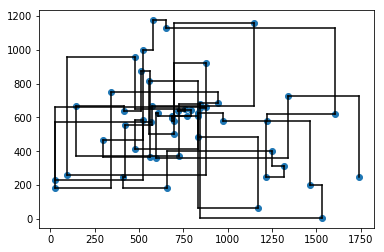

Length: 27815


In [62]:
def plot_initial():
    X = prepare_points()
    plot_route(X, np.arange(X.shape[0]))
    print('Length: {}'.format(get_route_length(X, np.arange(X.shape[0]))))

plot_initial()

#### 4) (2) Implement a Monte-Carlo search.

In [39]:
def get_monte_carlo_search_route(points, iterations_amount=10**5):
    n = points.shape[0]
    current_perm = np.random.permutation(n)
    current_length = get_route_length(points, current_perm)
    for _ in tqdm(range(iterations_amount)):
        next_perm = np.random.permutation(n)
        next_length = get_route_length(points, next_perm)
        if next_length < current_length:
            current_length = next_length
            current_perm = next_perm
    
    return current_perm, current_length

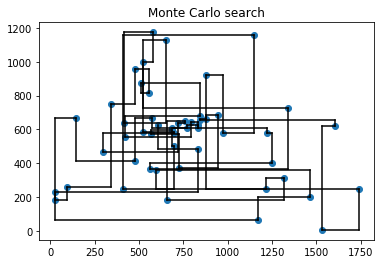

Length: 27075


In [63]:
def task4():
    X = prepare_points()
    route, length = get_monte_carlo_search_route(X)
    plot_route(X, route, 'Monte Carlo search')
    print('Length: {}'.format(length))
    
task4()

As we can see, Monte Carlo search with $10^6$ iterations is a bit better than the initial order

#### 5) (2) Implement a random walk search.

Let's implement a random walk, where we choice random (with distribution ~ inverse distances) neighbor (not visited yet point). And then we will repeat the process several times

In [104]:
def random_walk_iteration(points):
    n = points.shape[0]
    perm = []
    visited = np.zeros(n, dtype=np.bool)
    prev_point_ind = -1
    dists = np.array([[get_manhattan_distance(points[first], points[second]) if first != second else 1 
                       for first in range(n)] for second in range(n)])
    inv_dists = 1. / dists
    for _ in range(n):
        not_visited_points = np.where(visited == False)[0]
        if prev_point_ind == -1:
            next_point_ind = np.random.choice(not_visited_points)
        else:
            current_dists = inv_dists[prev_point_ind, not_visited_points]
            probabilities = current_dists / np.sum(current_dists)
            next_point_ind = np.random.choice(not_visited_points, p=probabilities)
        perm.append(next_point_ind)
        visited[next_point_ind] = True
        prev_point_ind = next_point_ind
        
    return np.array(perm)

def get_random_walk_route(points, iterations_amount=10**3):
    current_perm = None
    current_length = 0
    for _ in tqdm(range(iterations_amount)):
        perm = random_walk_iteration(points)
        length = get_route_length(points, perm)
        if current_perm is None or length < current_length:
            current_length = length
            current_perm = perm
    
    return current_perm, current_length

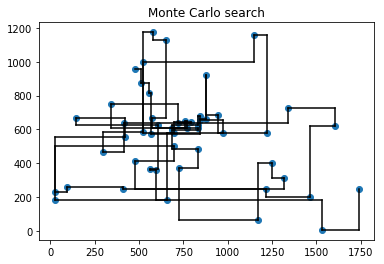

Length: 20850


In [105]:
def task5():
    X = prepare_points()
    route, length = get_random_walk_route(X)
    plot_route(X, route, 'Monte Carlo search')
    print('Length: {}'.format(length))

task5()

As we can see, such a random walk is much better than the Monte Carlo search and initial order both

#### 6) (4) Implement a hill climb algorithm.


In [ ]:
def task6():
    pass

task6()